# 데이콘 이상탐지 데이터 분석
---

In [ ]:
!pip install --upgrade matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.signal import butter, filtfilt
import pywt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import shap

![관망구조B](관망구조_B.jpg)

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

1. 1-2단계 조합 전략
1단계(100% 정확도)로 필터링된 400개 데이터를 기준으로 함
2단계(90% 정확도)의 예측을 보조 지표로 활용
두 모델의 예측이 일치하는 구간은 높은 신뢰도로 anomaly로 판단
불일치하는 구간은 3단계에서 더 엄격한 기준 적용
2. 3단계 Pi_flag 탐지 전략
시계열 패턴 기반 접근
연속성 확인
첫 번째 이미지처럼 급격한 하락 후 회복 패턴 확인
하락 지속 시간이 일정 기간 이상인 경우만 고려
동시성 탐지
두 번째 이미지처럼 P7-P9의 동시 하락 패턴 확인
상관행렬에서 보이는 인접 압력계 간 높은 상관관계 활용
앙상블 규칙
필수 조건
1단계에서 anomaly로 탐지된 구간
연속된 압력계의 동시 하락
하락 후 회복 패턴 존재
보조 조건
2단계 모델의 anomaly 예측
하락 특성(magnitude, duration, speed) 중 2개 이상 임계값 초과
인접 압력계와의 상관계수가 임계값 이상
최종 판단
필수 조건을 모두 만족하고
보조 조건 중 2개 이상 만족 시 Pi_flag=1로 설정
이러한 앙상블 접근은 네 번째 이미지에서 보이는 것처럼 실제 flag 변화를 더 정확하게 포착할 수 있습니다.



# 1단계

In [2]:
df_A = pd.read_csv("TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성: Q5 - (Q1 + Q2 + Q3 + Q4)
df_A['leakage'] = df_A['Q1'] + df_A['Q2'] + df_A['Q3'] + df_A['Q4'] - df_A['Q5']
#df_A['leakage_diff'] = df_A['leakage'].diff()

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


In [3]:
# 2. 양수 leakage만 필터링
positive_mask = df_A['leakage'] > 0
df_positive = df_A[positive_mask].copy()

In [4]:
# 2. Isolation Forest 모델 정의
iso_forest = IsolationForest(
    contamination=0.03,  # anomaly 비율
    random_state=42,
    n_estimators=100
)

In [5]:
# 3. 학습 데이터 준비 (leakage만 사용)
X = df_A['leakage'].values.reshape(-1, 1)
iso_forest.fit(X)

IsolationForest(contamination=0.03, random_state=42)

In [6]:
# 4. Anomaly 예측
anomaly_pred = iso_forest.predict(X)
df_A['predicted_anomaly'] = np.where(anomaly_pred == -1, 1, 0)

In [7]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

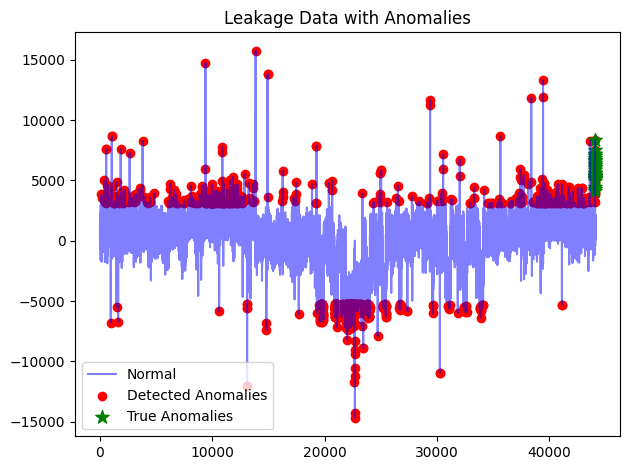

In [8]:
# Leakage 데이터와 예측된/실제 anomaly 플롯
plt.plot(df_A.index, df_A['leakage'], 'b-', label='Normal', alpha=0.5)
plt.scatter(df_A.index[df_A['predicted_anomaly'] == 1],
           df_A['leakage'][df_A['predicted_anomaly'] == 1],
           color='red', label='Detected Anomalies')
plt.scatter(df_A.index[df_A['anomaly'] == 1],
           df_A['leakage'][df_A['anomaly'] == 1],
           color='green', marker='*', s=100, label='True Anomalies')
plt.title('Leakage Data with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# 6. 성능 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
detected_anomalies = df_A[df_A['predicted_anomaly'] == 1]
matching = df_A[(df_A['anomaly'] == 1) & (df_A['predicted_anomaly'] == 1)]

print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")

실제 anomaly 수: 30
탐지된 anomaly 수: 1323
일치하는 anomaly 수: 30
탐지 정확도: 100.00%


In [10]:
# 7. 주요 anomaly 시점 출력
print("\n주요 anomaly 발생 시점:")
print(true_anomalies[['timestamp', 'leakage']].head())


주요 anomaly 발생 시점:
            timestamp   leakage
44061  24/06/26 14:21  6002.004
44062  24/06/26 14:22  6310.001
44063  24/06/26 14:23  6719.001
44064  24/06/26 14:24  5627.004
44065  24/06/26 14:25  5078.004


In [11]:
# 4. 예측
X = df_positive['leakage'].values.reshape(-1, 1)
df_positive['predicted_anomaly'] = np.where(iso_forest.predict(X) == -1, 1, 0)

In [12]:
# 5. 시각화
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

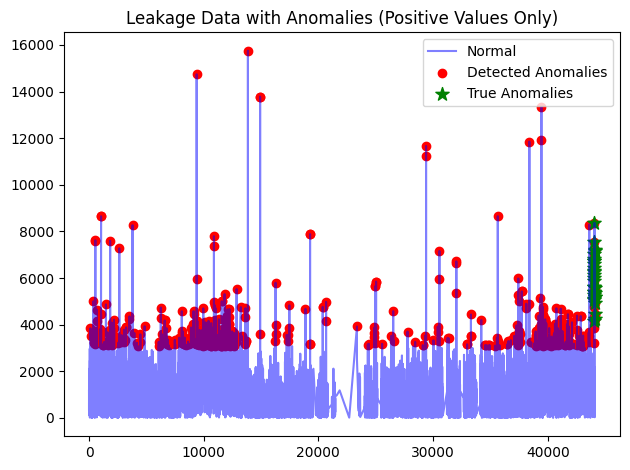

In [13]:
# 전체 데이터 플롯 (양수 값만)
plt.plot(df_positive.index, df_positive['leakage'], 
         'b-', label='Normal', alpha=0.5)

# 탐지된 anomaly 플롯
plt.scatter(df_positive.index[df_positive['predicted_anomaly'] == 1],
           df_positive['leakage'][df_positive['predicted_anomaly'] == 1],
           color='red', label='Detected Anomalies')
# 실제 anomaly 플롯
plt.scatter(df_positive.index[df_positive['anomaly'] == 1],
           df_positive['leakage'][df_positive['anomaly'] == 1],
           color='green', marker='*', s=100, label='True Anomalies')

plt.title('Leakage Data with Anomalies (Positive Values Only)')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# 6. 성능 평가
true_anomalies = df_positive[df_positive['anomaly'] == 1]
detected_anomalies = df_positive[df_positive['predicted_anomaly'] == 1]
matching = df_positive[(df_positive['anomaly'] == 1) & 
                      (df_positive['predicted_anomaly'] == 1)]

In [15]:
print(f"실제 anomaly 수: {len(true_anomalies)}")
print(f"탐지된 anomaly 수: {len(detected_anomalies)}")
print(f"일치하는 anomaly 수: {len(matching)}")
print(f"탐지 정확도: {len(matching)/len(true_anomalies)*100:.2f}%")

실제 anomaly 수: 30
탐지된 anomaly 수: 633
일치하는 anomaly 수: 30
탐지 정확도: 100.00%


In [16]:
# predicted_anomaly를 stage1_anomaly로 변경
df_positive = df_positive.rename(columns={'predicted_anomaly': 'stage1_anomaly'})

In [17]:
# 1단계에서 필터링된 데이터 선택
filtered_df = df_positive[df_positive['stage1_anomaly'] == 1].copy()

## 2단계  Iso Pi  패턴 감지

## 전처리

In [20]:
def preprocessing(df, pressure_cols, ema_span=20):
    preprocessed_features = {}
    
    for col in pressure_cols:
        # 1. EMA로 노이즈 제거
        ema = df[col].ewm(span=ema_span, adjust=False).mean()
        
        # 2. 하락 구간 식별
        gradient = ema.diff()
        drop_mask = gradient < 0
        
        # 3. 하락 구간 특성 추출
        # 하락 기간: 연속된 하락 구간의 길이
        drop_duration = pd.Series(0, index=df.index)
        duration_count = 0
        for i, is_dropping in enumerate(drop_mask):
            if is_dropping:
                duration_count += 1
            else:
                duration_count = 0
            drop_duration.iloc[i] = duration_count
        
        # 하락 폭: 시작점 대비 현재 하락량
        drop_magnitude = pd.Series(0.0, index=df.index)
        start_value = ema.iloc[0]
        for i, is_dropping in enumerate(drop_mask):
            if is_dropping:
                drop_magnitude.iloc[i] = start_value - ema.iloc[i]
            else:
                start_value = ema.iloc[i]
        
        # 하락 속도: gradient의 크기
        drop_speed = gradient.abs() * drop_mask
        
        # 결과 저장
        preprocessed_features[f'{col}_ema'] = ema
        preprocessed_features[f'{col}_drop_duration'] = drop_duration
        preprocessed_features[f'{col}_drop_magnitude'] = drop_magnitude
        preprocessed_features[f'{col}_drop_speed'] = drop_speed
        
    return pd.DataFrame(preprocessed_features, index=df.index)

In [21]:
# 전처리 적용
pressure_cols = [f'P{i}' for i in range(1, 27)]
preprocessed_df = preprocessing(df_A, pressure_cols)

In [22]:
def detect_pressure_anomalies_stage2(preprocessed_df, pressure_cols, contamination=0.1):
    drop_features = []
    for col in pressure_cols:
        drop_features.extend([
            f'{col}_drop_duration',
            f'{col}_drop_magnitude',
            f'{col}_drop_speed'
        ])
    
    features_df = preprocessed_df[drop_features].fillna(0)
    
    iso = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    predictions = iso.fit_predict(X_scaled)
    anomalies = np.where(predictions == -1, 1, 0)
    
    results = pd.DataFrame(index=preprocessed_df.index)
    results['stage2_anomaly'] = anomalies
    
    return results

In [23]:
# 2단계 모델 적용
stage2_results = detect_pressure_anomalies_stage2(preprocessed_df, pressure_cols)

In [25]:
# Stage 2 Anomaly 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
predicted_anomalies = stage2_results[stage2_results['stage2_anomaly'] == 1]
matching_anomalies = len(set(true_anomalies.index) & set(predicted_anomalies.index))

print("=== Stage 2 Anomaly 평가 결과 ===")
print(f"실제 Anomaly 수: {len(true_anomalies)}")
print(f"예측된 Anomaly 수: {len(predicted_anomalies)}")
print(f"일치하는 Anomaly 수: {matching_anomalies}")
print(f"탐지 정확도: {matching_anomalies/len(true_anomalies)*100:.2f}%")


=== Stage 2 Anomaly 평가 결과 ===
실제 Anomaly 수: 30
예측된 Anomaly 수: 4410
일치하는 Anomaly 수: 28
탐지 정확도: 93.33%


In [29]:
# 1단계와 2단계 결과 결합
final_results = pd.DataFrame(index=df_A.index)
final_results['stage1_anomaly'] = 0
final_results.loc[df_positive.index, 'stage1_anomaly'] = df_positive['stage1_anomaly']
final_results['stage2_anomaly'] = stage2_results['stage2_anomaly']

# AND 연산으로 두 단계에서 모두 anomaly로 예측된 경우만 선택
final_results['final_anomaly'] = ((final_results['stage1_anomaly'] == 1) & 
                                 (final_results['stage2_anomaly'] == 1)).astype(int)

In [30]:
# 평가
true_anomalies = df_A[df_A['anomaly'] == 1]
stage1_predicted = final_results[final_results['stage1_anomaly'] == 1]
stage2_predicted = final_results[final_results['stage2_anomaly'] == 1]
final_predicted = final_results[final_results['final_anomaly'] == 1]


In [31]:
# 각 단계별 매칭 확인
stage1_matching = len(set(true_anomalies.index) & set(stage1_predicted.index))
stage2_matching = len(set(true_anomalies.index) & set(stage2_predicted.index))
final_matching = len(set(true_anomalies.index) & set(final_predicted.index))

print("=== 단계별 Anomaly 평가 결과 ===")
print("\nStage 1:")
print(f"예측된 Anomaly 수: {len(stage1_predicted)}")
print(f"일치하는 Anomaly 수: {stage1_matching}")

print("\nStage 2:")
print(f"예측된 Anomaly 수: {len(stage2_predicted)}")
print(f"일치하는 Anomaly 수: {stage2_matching}")

print("\nFinal (Stage 1 & 2 교집합):")
print(f"실제 Anomaly 수: {len(true_anomalies)}")
print(f"예측된 Anomaly 수: {len(final_predicted)}")
print(f"일치하는 Anomaly 수: {final_matching}")
print(f"탐지 정확도: {final_matching/len(true_anomalies)*100:.2f}%")

=== 단계별 Anomaly 평가 결과 ===

Stage 1:
예측된 Anomaly 수: 633
일치하는 Anomaly 수: 30

Stage 2:
예측된 Anomaly 수: 4410
일치하는 Anomaly 수: 28

Final (Stage 1 & 2 교집합):
실제 Anomaly 수: 30
예측된 Anomaly 수: 95
일치하는 Anomaly 수: 28
탐지 정확도: 93.33%


Anomaly 기간을 30개 전후로 제한
연속된 압력계의 동시 하락 패턴 강화
하락 지속 기간이 최소 10 이상인 경우만 고려
너무 긴 이상 기간(50 초과)은 제외하여 false positive 감소
이러한 수정을 통해 세 번째와 네 번째 이미지에서 보이는 것처럼 P7-P9의 연속적인 하락 패턴을 더 정확하게 포착할 수 있습니다.